# Introduction to 1D Convolutional Neural Networks for NLP
This is the code corresponding to the CNN part of my notes [Introduction to CNNs and LSTMs for NLP](http://www.lix.polytechnique.fr/~anti5662/intro_cnn_lstm_tixier.pdf). I encourage you to have a look at these notes for a quick theoretical intro.

In this notebook, we use Python 3 and [Keras](https://keras.io/getting-started/faq/}) with `TensorFlow` backend to perform binary **movie review classification** (positive/negative) on the IMDB dataset (25K training, 25K testing) with the basic CNN architecture described in [CNNs for Sentence Classification (Kim, EMNLP 2014)](https://arxiv.org/abs/1408.5882). We also visualize **document embeddings**, **predictive regions** in the input documents, following [Effective Use of Word Order for Text Categorization with Convolutional Neural Networks (Johnson and Zhang, NAACL 2015)](https://arxiv.org/pdf/1412.1058.pdf), and first-order derivate **saliency maps**, following [Visualizing and Understanding Neural Models in NLP (Li et al. 2015)](https://arxiv.org/abs/1506.01066). 


## Environment setup

In [17]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import csv
import json
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim.models.word2vec import Word2Vec

from keras.models import Model, load_model
from keras import backend as K
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

print('packages loaded')

def extract_regions(tokens, filter_size):
    regions = []
    regions.append(' '.join(tokens[:filter_size]))
    for i in range(filter_size, len(tokens)):
        regions.append(' '.join(tokens[(i-filter_size+1):(i+1)]))
    return regions

print('functions defined')

path_root = # fill me 
path_to_IMDB = path_root + 'new_data\\'
path_to_pretrained_wv = # fill me
path_to_plot = path_root
path_to_save = path_root

packages loaded
functions defined


## Parameter values

Let's set the values of our parameters. Below are some explanations about the role of some parameters. The others are pretty self-explanatory.
* `use_pretrained`: whether to use pre-trained word embeddings or not (convergence is faster, and absolute accuracy is slightly greater)
* `max_features`: size of our vocab
* `stpwd_thd`: number of most frequent words to consider as stopwords
* `max_size`: maximum document size allowed
* `nb_epoch`: increasing the number of epochs may lead to overfitting when max_size is small (especially since dataset is small in the first place)
* `my_optimizer`: `adam` proved better than `SGD` and `Adadelta` in my experiments
* `my_patience`: for early stopping strategy (number of epochs without improvement to wait before we stop training)

Note that since we train on CPU, we select affordable parameter values. On GPU, we would be able to afford bigger vocab, longer maximum document size, more branches, and more filters per branch.

In [13]:
use_pretrained = True
name_save = 'my_cnn_two_branches.hdf5'
print('best model will be saved with name:',name_save)

max_features = int(2e4)
stpwd_thd = 1 
max_size = 200
word_vector_dim = int(3e2)
do_static = False
nb_filters = 150
filter_size_a = 3
filter_size_b = 4
drop_rate = 0.3
batch_size = 64
nb_epoch = 6
my_optimizer = 'adam' 
my_patience = 2

if not use_pretrained:
    # if the embeddings are initialized randomly, using static mode doesn't make sense
    do_static = False
    print("not using pre-trained embeddings, overwriting 'do_static' argument")

best model will be saved with name: my_cnn_two_branches.hdf5


## Data loading and further preprocessing
### Reading and inspection
Let's read the data. The raw data have already been pre-processed by me in this [script](https://github.com/Tixierae/deep_learning_NLP/blob/master/CNN_IMDB/imdb_preprocess_new.py). `word_to_index` is a dictionary of word indexes sorted by decreasing frequency across the corpus. It is a 1-based index, as 0 is reserved for zero-padding.

In [3]:
with open(path_to_IMDB + 'word_to_index.json', 'r') as my_file:
    word_to_index = json.load(my_file)

# examples:
print('index of "the":',word_to_index['the']) # most frequent word
print('index of "movie":',word_to_index['movie']) # very frequent word
print('index of "!":',word_to_index['!']) # very frequent punctuation mark
print('index of ":)":',word_to_index[':)']) # frequent emoji
print('index of "elephant":',word_to_index['elephant']) # less frequent word
print('index of "dreaded":',word_to_index['dreaded']) # very infrequent word

index of "the": 1
index of "movie": 18
index of "!": 33
index of ":)": 2612
index of "elephant": 8150
index of "dreaded": 12478


In [4]:
with open(path_to_IMDB + 'training.csv', 'r') as my_file:
    reader = csv.reader(my_file, delimiter=',')
    x_train = list(reader)

with open(path_to_IMDB + 'test.csv', 'r') as my_file:
    reader = csv.reader(my_file, delimiter=',')
    x_test = list(reader)

with open(path_to_IMDB + 'training_labels.txt', 'r') as my_file:
    y_train = my_file.read().splitlines()

with open(path_to_IMDB + 'test_labels.txt', 'r') as my_file:
    y_test = my_file.read().splitlines()

# turn lists of strings into lists of integers
x_train = [[int(elt) for elt in sublist] for sublist in x_train]
x_test = [[int(elt) for elt in sublist] for sublist in x_test]  

y_train = [int(elt) for elt in y_train]
y_test = [int(elt) for elt in y_test]

print('data loaded')

data loaded


We can verify what our data look like by inverting the `word_to_index` dictionary and comparing a random review to the real one: [https://www.imdb.com/review/rw1958804/?ref_=tt_urv](https://www.imdb.com/review/rw1958804/?ref_=tt_urv):

In [5]:
index_to_word = dict((v,k) for k, v in word_to_index.items())
print (' '.join([index_to_word[elt] for elt in x_train[4]]))

Although i had heard this film was a little dry , I watch whatever Scott Bakula is in . At the start of this film I had high hopes for the classic cheesy but enjoyable Scott-gets-girl ending and until 20 minutes before the end it was going great . The plot twist was crazy and unexpected and very clever . I kept my fingers crossed that it would work out and it would all be some horrible misunderstanding , right up until when the credits rolled and I realised that there was not going to be a happy and contented ending . Unfortunately i was left regretting that i'd watched it and hurriedly putting on some quantum leap to restore my faith in the goodness of the Great Scott !


### Stopwords and out-of-vocab words removal
We only take into account the `max_features` most frequent words and disregard the `stopword_threhsold` most frequent words. Here, we don't remove any stopwords as some of them might be useful for classification ('but','not', etc.) and the model is supposed to be pretty robust to the presence of unpredictive features, as it automatically learns which features are the most discriminative.

In [6]:
stpwds = [index_to_word[idx] for idx in range(1,stpwd_thd)]
print('stopwords are:',stpwds)

x_train = [[elt for elt in rev if elt<=max_features and elt>=stpwd_thd] for rev in x_train]
x_test =  [[elt for elt in rev if elt<=max_features and elt>=stpwd_thd] for rev in x_test]

print('pruning done')

stopwords are: []
pruning done


### Truncation and zero-padding
We truncate reviews of size larger than `max_size` to their `max_size` first words. We also pad reviews shorter than `max_size` with the zero vector reserved for padding (0th index):

In [7]:
x_train = [rev[:max_size] for rev in x_train]
x_test = [rev[:max_size] for rev in x_test]

print('padding',len([elt for elt in x_train if len(elt)<max_size])
,'reviews from the training set')

x_train = [rev+[0]*(max_size-len(rev)) if len(rev)<max_size else rev for rev in x_train]

# sanity check: all reviews should now be of size 'max_size'
assert(max_size == list(set([len(rev) for rev in x_train]))[0]),"1st sanity check failed!"

print('padding',len([elt for elt in x_test if len(elt)<max_size]),'reviews from the test set')

x_test = [rev+[0]*(max_size-len(rev)) if len(rev)<max_size else rev for rev in x_test]

# sanity check
assert(max_size == list(set([len(rev) for rev in x_test]))[0]),"2nd sanity check failed!"

print('truncation and padding done')

padding 13461 reviews from the training set
padding 13708 reviews from the test set
truncation and padding done


### Loading pre-trained word vectors

300-dimensional word embeddings learned with word2vec on the GoogleNews dataset can be downloaded from https://code.google.com/archive/p/word2vec/Google, under the section "Pre-trained word and phrase vectors". Using `gensim`, we can load only the vectors of the words found in our vocabulary and save some RAM. This takes about 90s on my laptop.

* Note 1: when using the `intersect_word2vec_format` method, in-vocab words without an entry in the binary file are not removed from the vocabulary. Instead, their vectors are silently initialized to random values. We can detect those vectors via their norms which approach zero. This is what we do in lines `25-28`. Most of those words are proper nouns, which don't have an entry in the word vectors file because we lowercased the text. Those words will start as random and be tuned during training.

* Note 2: lines `31-35`, we create and fill an embedding table of size `max_features + 1`, ignoring stopword removal and truncation. E.g., if `max_features = 2e4`, reviews will be composed of integers from `1` to `2e4` (plus `0` after padding). But after truncation and stopword removal, the vocabulary size (number of unique integer values) may become smaller. So, if the input dim is based on the final vocab size, some integers in the range `[1,2e4]` won't have a row anymore in the embedding table. This is why we create the embedding lookup table based on the original `max_features +1` value, knowing that the rows of the words that have been removed just won't be looked up.  

In [8]:
# convert integer reviews into word reviews
x_full = x_train + x_test
x_full_words = [[index_to_word[idx] for idx in rev if idx!=0] for rev in x_full]
all_words = [word for rev in x_full_words for word in rev]

print(len(all_words),'words')
print(len(list(set(all_words))),'unique words')

if use_pretrained:

    # initialize word vectors
    word_vectors = Word2Vec(size=word_vector_dim, min_count=1)

    # create entries for the words in our vocabulary
    word_vectors.build_vocab(x_full_words)

    # sanity check
    assert(len(list(set(all_words))) == len(word_vectors.wv.vocab)),"3rd sanity check failed!"

    # fill entries with the pre-trained word vectors
    word_vectors.intersect_word2vec_format(path_to_pretrained_wv + 'GoogleNews-vectors-negative300.bin.gz', binary=True)

    print('pre-trained word vectors loaded')

    norms = [np.linalg.norm(word_vectors[word]) for word in list(word_vectors.wv.vocab)] # in Python 2.7: word_vectors.wv.vocab.keys()
    idxs_zero_norms = [idx for idx, norm in enumerate(norms) if norm<0.05]
    no_entry_words = [list(word_vectors.wv.vocab)[idx] for idx in idxs_zero_norms]
    print('# of vocab words w/o a Google News entry:',len(no_entry_words))

    # create numpy array of embeddings  
    embeddings = np.zeros((max_features + 1,word_vector_dim))
    for word in list(word_vectors.wv.vocab):
        idx = word_to_index[word]
        # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
        embeddings[idx,] = word_vectors[word]
        
    print('embeddings created')

else:
    print('not using pre-trained embeddings')

8224882 words
20000 unique words
pre-trained word vectors loaded
# of vocab words w/o a Google News entry: 1139
embeddings created


## Defining CNN
For efficiency reasons, we will only implement two branches of the following architecture: 

<img src="https://github.com/Tixierae/deep_learning_NLP/raw/master/CNN_IMDB/cnn_illustration.png" alt="Drawing" style="width: 400px;"/>

By branch, I mean the part of the architecture that corresponds to a given filter size (e.g., the upper red part is one branch).

In [9]:
my_input = Input(shape=(max_size,)) # we leave the 2nd argument of shape blank because the Embedding layer cannot accept an input_shape argument

if use_pretrained:
    embedding = Embedding(input_dim=embeddings.shape[0], # vocab size, including the 0-th word used for padding
                          output_dim=word_vector_dim,
                          weights=[embeddings], # we pass our pre-trained embeddings
                          input_length=max_size,
                          trainable=not do_static,
                          ) (my_input)
else:
    embedding = Embedding(input_dim=max_features + 1,
                          output_dim=word_vector_dim,
                          trainable=not do_static,
                          ) (my_input)

embedding_dropped = Dropout(drop_rate)(embedding)

# feature map size should be equal to max_size-filter_size+1
# tensor shape after conv layer should be (feature map size, nb_filters)
print('branch A:',nb_filters,'feature maps of size',max_size-filter_size_a+1)
print('branch B:',nb_filters,'feature maps of size',max_size-filter_size_b+1)

# A branch
conv_a = Conv1D(filters = nb_filters,
              kernel_size = filter_size_a,
              activation = 'relu',
              )(embedding_dropped)

pooled_conv_a = GlobalMaxPooling1D()(conv_a)

pooled_conv_dropped_a = Dropout(drop_rate)(pooled_conv_a)

# B branch
conv_b = Conv1D(filters = nb_filters,
              kernel_size = filter_size_b,
              activation = 'relu',
              )(embedding_dropped)

pooled_conv_b = GlobalMaxPooling1D()(conv_b)

pooled_conv_dropped_b = Dropout(drop_rate)(pooled_conv_b)

concat = Concatenate()([pooled_conv_dropped_a,pooled_conv_dropped_b])

concat_dropped = Dropout(drop_rate)(concat)

# we finally project onto a single unit output layer with sigmoid activation
prob = Dense(units = 1, # dimensionality of the output space
             activation = 'sigmoid',
             )(concat_dropped)

model = Model(my_input, prob)

model.compile(loss='binary_crossentropy',
              optimizer = my_optimizer,
              metrics = ['accuracy'])

print('model compiled')

branch A: 150 feature maps of size 198
branch B: 150 feature maps of size 197
model compiled


We can print a summary of the model with `model.summary()`, and access the individual layers of the model with `model.layers`, then, the input/output shape of each layer with, e.g., `model.layers[0].input_shape` or `model.layers[0].output_shape`. For instance:

In [10]:
model.summary()
model.layers[4].output_shape # dimensionality of document encodings (nb_filters*2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     6000300     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 198, 150)     135150      dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

(None, 197, 150)

### Number of parameters of the model
* embedding layer: the number of entries in the embedding layer (`max_features` x `word_vector_dim`)
* conv layer: `filter_size` x filter depth (`word_vector_dim`) x `nb_filters` + `nb_filters` (one bias for each filter)
* dense layer: input size x output size + one bias

In [11]:
print('total number of model parameters:',model.count_params())

total number of model parameters: 6315901


### Visualization of document embeddings before training
We extract the output of the final embedding layer (before the softmax), which gives the encoding of the input document for some documents (`n_plot`) of the test set. We then visualize a low-dimensional map of the embeddings. We can see that before training, the documents are dispersed randomly in the space (which makes sense).

plotting embeddings of first 1000 documents


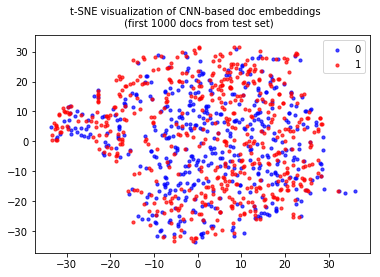

In [12]:
# in test mode, we should set the 'learning_phase' flag to 0 (we don't want to use dropout)
get_doc_embedding = K.function([model.layers[0].input,K.learning_phase()],
                               [model.layers[9].output])

n_plot = 1000
print('plotting embeddings of first',n_plot,'documents')

doc_emb = get_doc_embedding([np.array(x_test[:n_plot]),0])[0]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
doc_emb_pca = my_pca.fit_transform(doc_emb) 
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca)

labels_plt = y_test[:n_plot]
my_colors = ['blue','red']

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
    idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
    ax.scatter(doc_emb_tsne[idxs,0], 
               doc_emb_tsne[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=10)
fig.set_size_inches(6,4)
#fig.savefig(path_to_plot + 'doc_embeddings_init.pdf',bbox_inches='tight')
fig.show()

## Training CNN
We train the model on CPU (warning: by default, will use all the cores of the machine!). Note you can get a significant speedup by using a GPU. We also add two callbacks:
* the first one ensures that training stops after `my_patience` epochs without improvement in test set accuracy (early stopping strategy)
* the second one (checkpointer) saves the model to disk for every epoch for which there is improvement. Therefore, at the end of training, the model saved on disk will be the one corresponding to the best epoch and we can reload it.

In [14]:
early_stopping = EarlyStopping(monitor='val_acc', # go through epochs as long as accuracy on validation set increases
                               patience=my_patience,
                               mode='max')

# make sure that the model corresponding to the best epoch is saved
checkpointer = ModelCheckpoint(filepath=path_to_save + name_save,
                               monitor='val_acc',
                               save_best_only=True,
                               verbose=0)

model.fit(x_train, 
          y_train,
          batch_size = batch_size,
          epochs = nb_epoch,
          validation_data = (x_test, y_test),
          callbacks = [early_stopping,checkpointer])

Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 623s 25ms/step - loss: 0.4647 - acc: 0.7711 - val_loss: 0.3315 - val_acc: 0.8540
Epoch 2/6
25000/25000 [==============================] - 633s 25ms/step - loss: 0.2892 - acc: 0.8801 - val_loss: 0.3006 - val_acc: 0.8702
Epoch 3/6
25000/25000 [==============================] - 612s 24ms/step - loss: 0.2041 - acc: 0.9202 - val_loss: 0.3166 - val_acc: 0.8675
Epoch 4/6
25000/25000 [==============================] - 544s 22ms/step - loss: 0.1376 - acc: 0.9495 - val_loss: 0.3542 - val_acc: 0.8620


We want to make sure we load the model corresponding to the best epoch:

In [15]:
model = load_model(path_to_save + name_save)

## Visualizing and understanding CNN

### Document embeddings after training
We can see that after only a few epochs, our model has already learned meaningful internal representations:

plotting embeddings of first 1000 documents


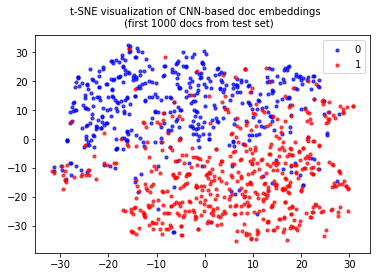

In [16]:
print('plotting embeddings of first',n_plot,'documents')

doc_emb = get_doc_embedding([np.array(x_test[:n_plot]),0])[0]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10)
doc_emb_pca = my_pca.fit_transform(doc_emb) 
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca)

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
    idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
    ax.scatter(doc_emb_tsne[idxs,0], 
               doc_emb_tsne[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=10)
fig.set_size_inches(6,4)
#fig.savefig(path_to_plot + 'doc_embeddings.pdf',bbox_inches='tight')
fig.show()

### Predictive text regions
Here we follow the approach of [Effective Use of Word Order for Text Categorization with Convolutional Neural Networks (Johnson and Zhang, NAACL 2015)](https://arxiv.org/pdf/1412.1058.pdf) (see Tables 5 and 6).

The feature maps that we find at the output of the convolutional layer provide region embeddings (in an `nb_filters`-dimensional space). For a given branch associated with `filter_size`, there are `max_size-filter_size+1` regions of size `filter_size` for an input of size `max_size`. For a given document, we want to identify the `n_show` regions of each branch that are associated with the highest weights in the corresponding feature maps. 

We can see that to classify the test set documents (which the model has never seen), the CNN uses regions of the input documents that make sense to us as humans. It picks up the compliments (`"I highly recommend"`, `"also very funny"`) and critics (`"were so poor"`, `"No screenplay , no"`).

In [18]:
get_region_embedding_a = K.function([model.layers[0].input,K.learning_phase()],
                                    [model.layers[3].output])

get_region_embedding_b = K.function([model.layers[0].input,K.learning_phase()],
                                    [model.layers[4].output])

get_softmax = K.function([model.layers[0].input,K.learning_phase()],
                         [model.layers[11].output])

n_doc_per_label = 2
idx_pos = [idx for idx,elt in enumerate(y_test) if elt==1]
idx_neg = [idx for idx,elt in enumerate(y_test) if elt==0]
my_idxs = idx_pos[:n_doc_per_label] + idx_neg[:n_doc_per_label]

x_test_my_idxs = np.array([x_test[elt] for elt in my_idxs])
y_test_my_idxs = [y_test[elt] for elt in my_idxs]

reg_emb_a = get_region_embedding_a([x_test_my_idxs,0])[0]
reg_emb_b = get_region_embedding_b([x_test_my_idxs,0])[0]

# predictions are probabilities of belonging to class 1
predictions = get_softmax([x_test_my_idxs,0])[0] 
# note: you can also use directly: predictions = model.predict(x_test[:100]).tolist()

n_show = 3 # number of most predictive regions we want to display

for idx,doc in enumerate(x_test_my_idxs):
        
    tokens = [index_to_word[elt] for elt in doc if elt!=0] # the 0 index is for padding
    
    # extract regions (sliding window over text)
    regions_a = extract_regions(tokens, filter_size_a)
    regions_b = extract_regions(tokens, filter_size_b)
    
    print('\n *********')
    print('===== text: =====')
    print(' '.join(tokens))
    print('===== label:',y_test_my_idxs[idx],'=====')
    print('===== prediction:',predictions[idx],'=====')
    norms_a = np.linalg.norm(reg_emb_a[idx,:,:],axis=1)
    norms_b = np.linalg.norm(reg_emb_b[idx,:,:],axis=1)
    print('===== most predictive regions of size',filter_size_a,': =====')
    print([elt for idxx,elt in enumerate(regions_a) if idxx in np.argsort(norms_a)[-n_show:]]) # 'np.argsort' sorts by increasing order
    print('===== most predictive regions of size',filter_size_b,': =====')
    print([elt for idxx,elt in enumerate(regions_b) if idxx in np.argsort(norms_b)[-n_show:]])
    


 *********
===== text: =====
My original title for this review was going to be , " Ending disappoints , Film triumphs . " But I actually thought about this one on the way home . It is not the fairy tale most of these films are , it takes turns that are different and while its ending is at first disappointing , it slowly sinks in and hits the core on a satisfying plot follows a man named James Aaron ( Your Jeff , who also wrote and directed ) a struggling actor who lives in Chicago with his mother and deals with both his and his inability to find someone to , it sounds corny , but it experiments with elements that make it somewhat unpredictable , and actually makes you wish it were longer . The ending came kind of abruptly and had me saying , " that's it ! ? " But once it starts to take it's toll , it really makes you does have many tones of seriousness throughout , but fear not , for it is also very funny . Some scenes offer huge laughs , and those who have seen Jeff stand-up will rec

### Saliency maps
Here we follow one of the approaches proposed in [Visualizing and Understanding Neural Models in NLP (Li et al. 2015)](https://arxiv.org/abs/1506.01066).

The idea is to rank the elements of the input document based on their influence on the prediction. An approximation can be given by the magnitudes of the first-order partial derivatives of the output of the model with respect to each word in the input document. The interpretation is that we identify which words in the document need to be *changed the least to change the class score the most*. The derivatives can be obtained by performing a single back-propagation pass. Note that here, we backpropagate the **class score** and not the loss (like we do during training).

You can view the saliency maps as vector graphics PDFs here: https://github.com/Tixierae/deep_learning_NLP/tree/master/CNN_IMDB

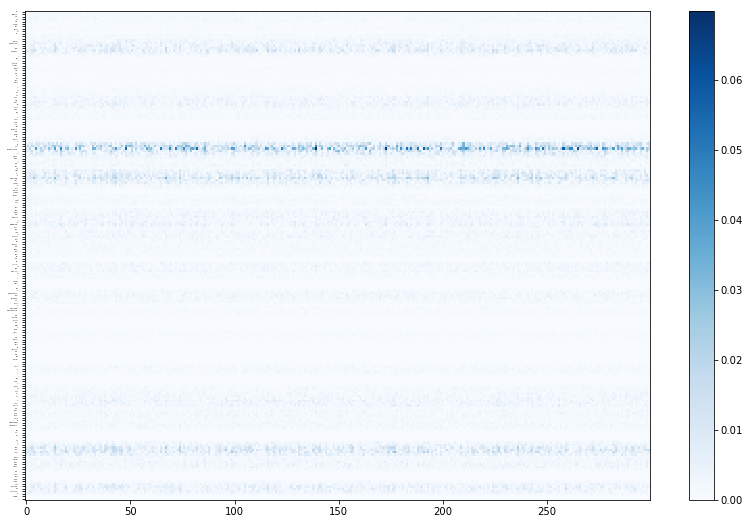

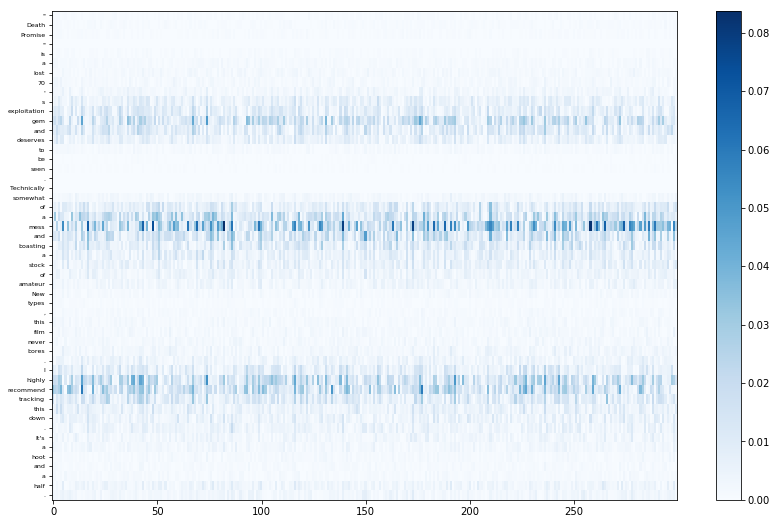

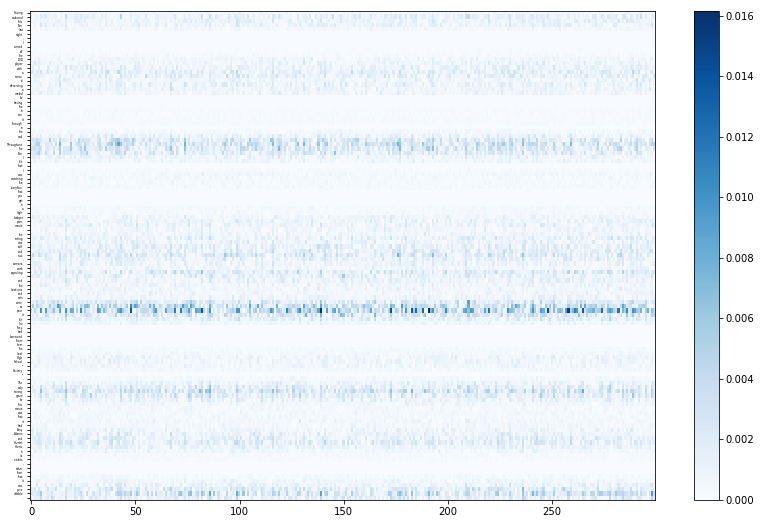

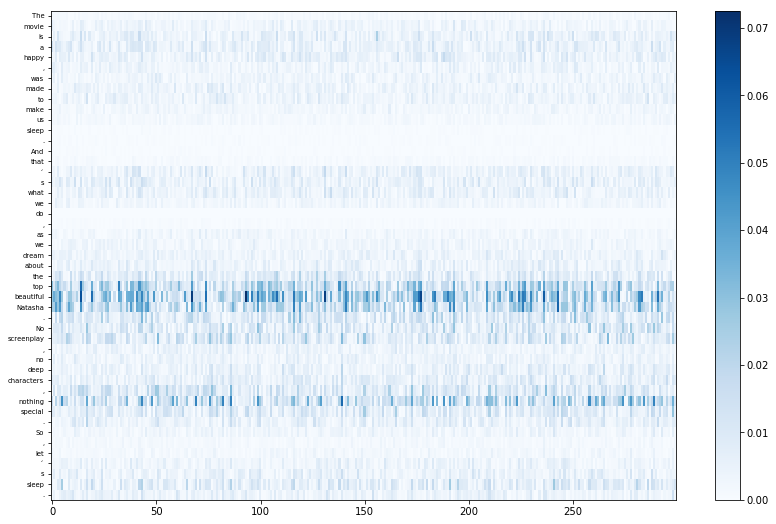

In [21]:
input_tensors = [model.input, K.learning_phase()]
saliency_input = model.layers[2].output # before split into branches
saliency_output = model.layers[11].output # class score
gradients = model.optimizer.get_gradients(saliency_output,saliency_input)
compute_gradients = K.function(inputs=input_tensors,outputs=gradients)

for idx,doc in enumerate(x_test_my_idxs):
    matrix = compute_gradients([np.array([doc]),0])[0][0,:,:]
    tokens = [index_to_word[elt] for elt in doc if elt!=0]
    to_plot = np.absolute(matrix[:len(tokens),:])
    fig, ax = plt.subplots()
    heatmap = ax.imshow(to_plot, cmap=plt.cm.Blues, interpolation='nearest',aspect='auto')
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_yticklabels(tokens)
    ax.tick_params(axis='y', which='major', labelsize=32*10/len(tokens))
    fig.colorbar(heatmap)
    fig.set_size_inches(14,9)
    fig.savefig(path_to_plot+'saliency_'+str(idx)+'.pdf',bbox_inches='tight')
    fig.show()

# Thank you for your interest!
If you found any error or have any suggestion for improvement, please file an issue on GitHub. You can also contact me at `antoine.tixier-1@colorado.edu`.
If you use some of the code in this repository in your own work, please cite:
* bibtex:
```
@article{tixier2018notes,
  title={Notes on Deep Learning for NLP},
  author={Tixier, Antoine J-P},
  journal={arXiv preprint arXiv:1808.09772},
  year={2018}
}
```
* plain text:
```
Tixier, Antoine J-P. "Notes on Deep Learning for NLP." arXiv preprint arXiv:1808.09772 (2018).
```